In [2]:
import gc
import os
import torch
import warnings
import numpy as np
import pandas as pd
import back_testing as bt
import matplotlib.pyplot as plt
from lib.utils import load_pickle
from lib.algos.base import BaseConfig
from lib.arfnn import SimpleGenerator

gc.collect()
warnings.filterwarnings("ignore")
np.random.seed(42)

# Function

In [3]:
def get_dataset_configuration(df_0):
    df_1 = df_0.dropna(axis=0)
    df_2 = df_1.pct_change().dropna()
    return df_2, np.array(df_2.mean()), np.array(df_2.std())


def value_at_risk(x: torch.Tensor, alpha: float) -> torch.Tensor:
    return torch.quantile(x, alpha, dim=0)


def expected_shortfall(x: torch.Tensor, alpha: float) -> torch.Tensor:
    var = value_at_risk(x, alpha)
    es = []
    for i in range(x.shape[1]):
        col = x[:, i]
        col_masked = col[col <= var[i]]
        es.append(col_masked.mean() if col_masked.numel() > 0 else torch.tensor(0.0, device=x.device))
    return torch.stack(es)


def compute_RE(P_real: np.ndarray, P_gen: np.ndarray, alpha: float) -> float:
    P_real = torch.tensor(P_real, dtype=torch.float32)
    P_gen = torch.tensor(P_gen, dtype=torch.float32)

    K = P_real.shape[1]
    VaR_real = value_at_risk(P_real, alpha)
    ES_real = expected_shortfall(P_real, alpha)
    VaR_gen = value_at_risk(P_gen, alpha)
    ES_gen = expected_shortfall(P_gen, alpha)

    return ((torch.abs(VaR_gen - VaR_real) / torch.abs(VaR_real) +
             torch.abs(ES_gen - ES_real) / torch.abs(ES_real)).sum() / (2 * K)).item()


def compute_SE(P_real: np.ndarray, P_sample: np.ndarray, alpha: float) -> float:
    P_real = torch.tensor(P_real, dtype=torch.float32)
    P_sample = torch.tensor(P_sample, dtype=torch.float32)

    K = P_real.shape[1]
    VaR_real = value_at_risk(P_real, alpha)
    ES_real = expected_shortfall(P_real, alpha)
    VaR_sample = value_at_risk(P_sample, alpha)
    ES_sample = expected_shortfall(P_sample, alpha)

    return ((torch.abs(VaR_sample - VaR_real) / torch.abs(VaR_real) +
             torch.abs(ES_sample - ES_real) / torch.abs(ES_real)).sum() / (2 * K)).item()


def estimate_VaR_ES(result_df, cl):
    VaR_array = result_df.apply(
        lambda col: np.percentile(col[pd.to_numeric(col, errors='coerce').notna()], cl)
        if col[pd.to_numeric(col, errors='coerce').notna()].size > 0 else np.nan,
        axis=0
    )
    mask = result_df.values[:, VaR_array.notna()] <= np.array(VaR_array.dropna())
    ES_array = np.where(mask, result_df.values[:, VaR_array.notna()], np.nan)
    ES_array = np.nanmean(ES_array, axis=0)
    return round(np.nanmean(VaR_array), 4), round(np.mean(ES_array), 4)


def simulate_rand_day(momentum_12m):
    random_idx = pd.to_datetime(np.random.choice(momentum_12m.index))
    rand_momentum_12m = momentum_12m.loc[random_idx:, :]
    weights = bt.dual_momentum_strategy(rand_momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result


def simulate_rand_company(price_df):
    random_cols = np.random.choice(price_df.columns, size=10, replace=False)
    df_ = price_df[random_cols]
    returns = bt.get_momentum(df_, 1)
    momentum_12m = bt.get_momentum(df_, 12)
    weights = bt.dual_momentum_strategy(momentum_12m)
    local_result = pd.DataFrame()
    local_result = bt.return_Table(weights, returns, local_result, True, 'Neutral', True, False)
    return local_result

# Real Price Scenario

In [4]:
price_df = pd.read_csv('./data/sp500.csv')
price_df.set_index('datadate', inplace=True)
df_ = price_df[['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOG', 'TSLA']].dropna(axis=0)
df_.index = pd.to_datetime(df_.index, format='%Y-%m-%d')
r_simple_real, mean, std = get_dataset_configuration(df_)

idx_df = pd.read_csv('./data/GSPC.csv', index_col='Date')
idx_df = idx_df.pct_change().apply(lambda x: np.log1p(x)).dropna()
idx_df.index = pd.to_datetime(idx_df.index, format='%Y-%m-%d')

returns = bt.get_momentum(df_, 1)
momentum_12m = bt.get_momentum(df_, 12)

weight_dict = {}
str_name_lst = ['static', 'MR', 'TF', 'DM', 'GTAA', 'GTAA5']

weight_dict[str_name_lst[0]] = bt.buy_and_hold_strategy(df_)
weight_dict[str_name_lst[1]] = bt.mean_reversion_zscore_strategy(df_)
weight_dict[str_name_lst[2]] = bt.trend_following_zscore_strategy(df_)
weight_dict[str_name_lst[3]] = bt.dual_momentum_strategy(momentum_12m)
weight_dict[str_name_lst[4]] = bt.gtaa_aggressive3_strategy(momentum_12m, df_)
weight_dict[str_name_lst[5]] = bt.gtaa5_momentum_strategy(momentum_12m, df_)

In [5]:
result_df_ori = pd.DataFrame()
for str_name in str_name_lst:
    result_df_ori = bt.return_Table(weight_dict[str_name], returns, result_df_ori, True, 'Neutral', True, 0.0002)

result_df_ori.columns = str_name_lst

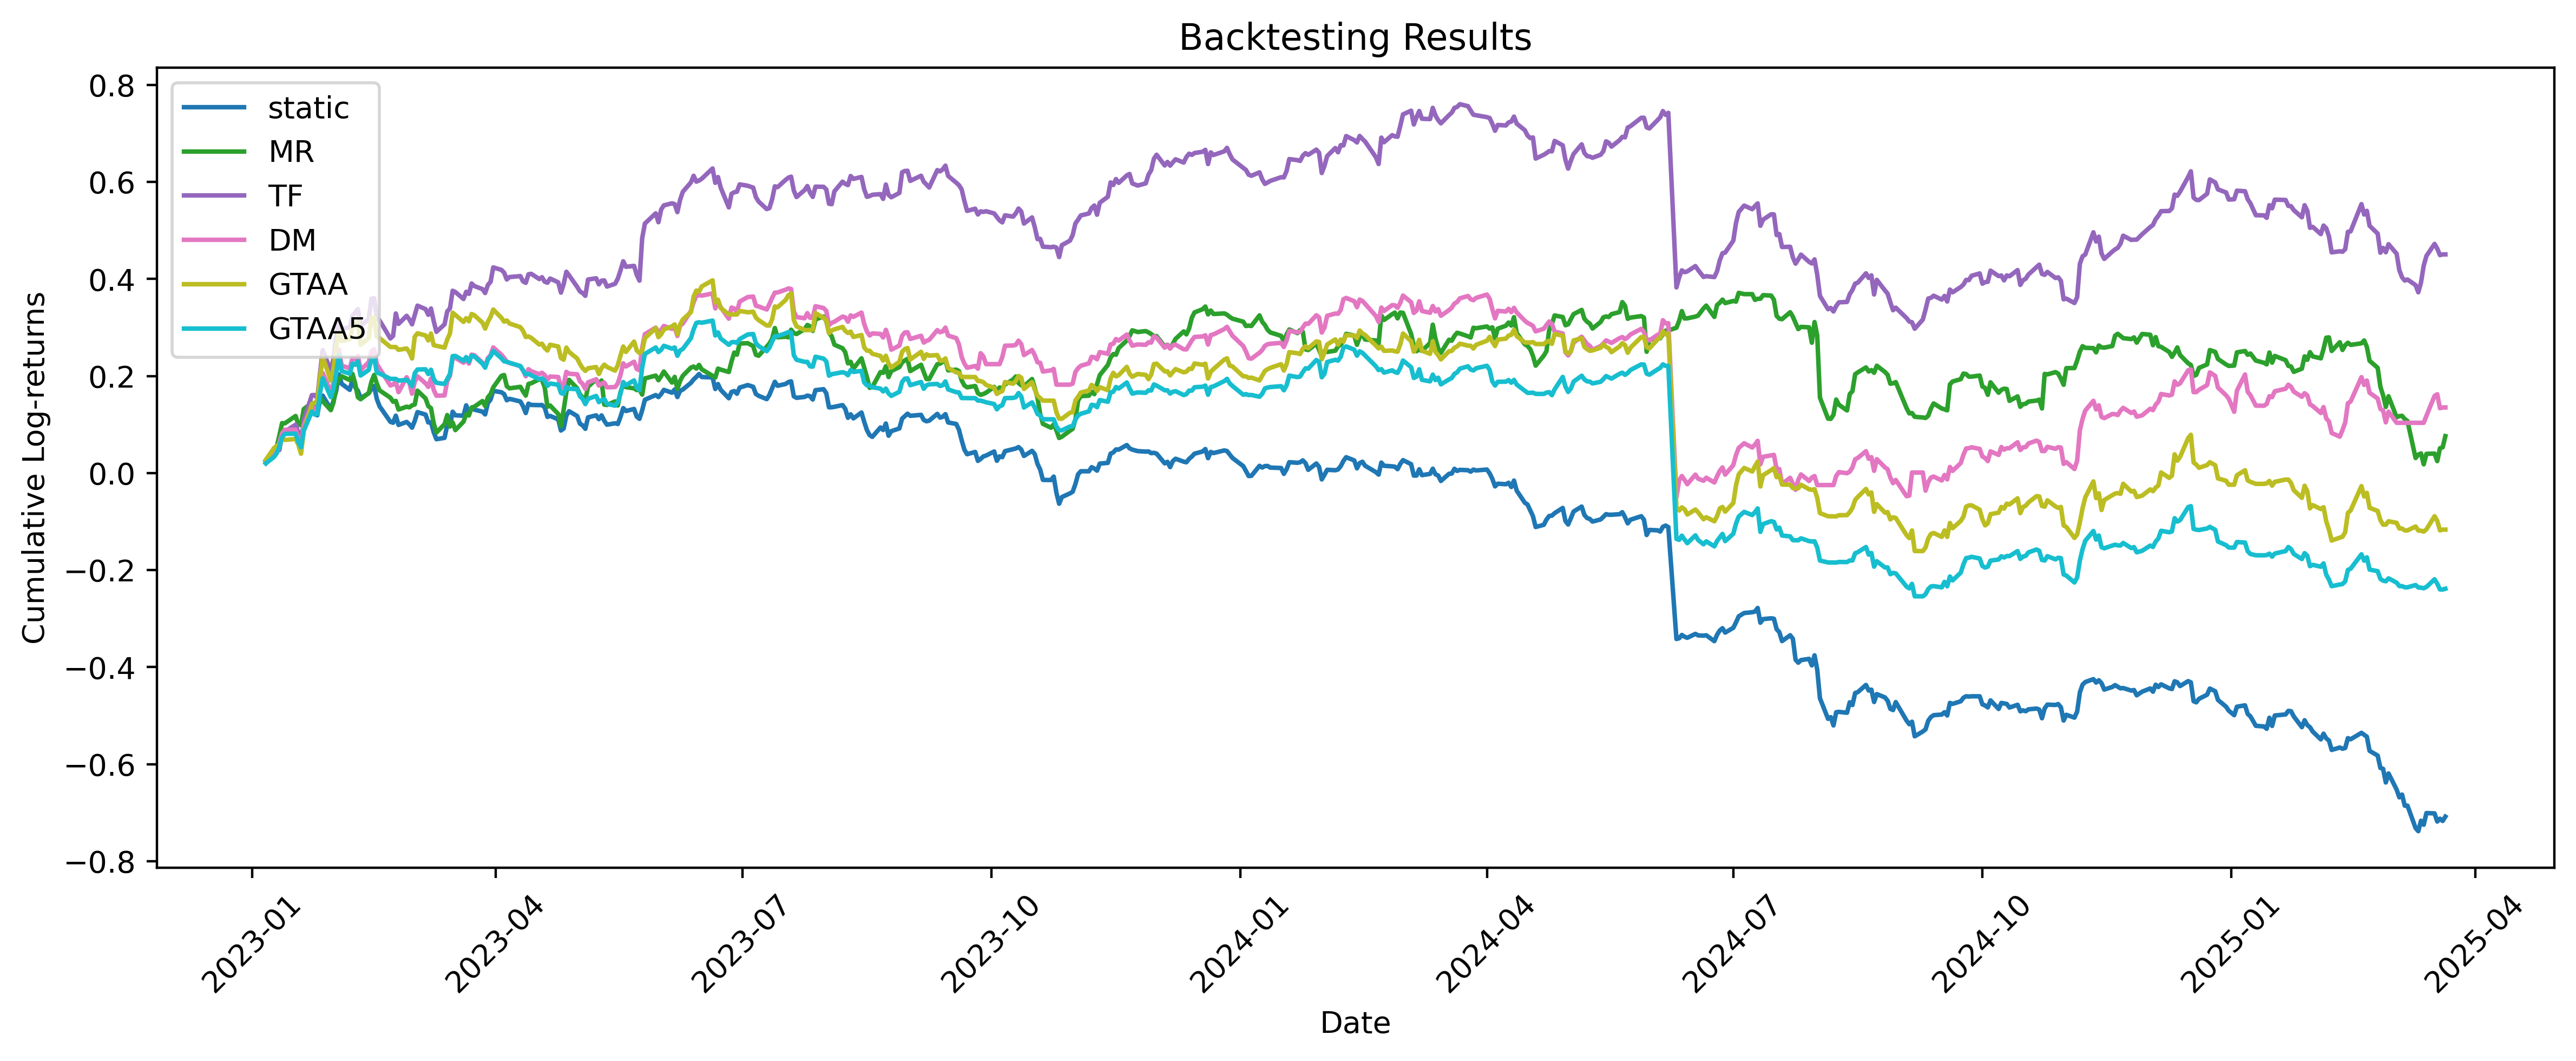

In [6]:
bt.plot_result(result_df_ori.loc[pd.to_datetime('2023-01-06'):].dropna(), True)

In [7]:
P_real = result_df_ori.loc[pd.to_datetime('2023-01-06'):].dropna().values
P_sample = P_real[np.random.choice(553, 5000)]
alpha = 0.05

SE_lst = []
for i in range(100):
    SE = compute_RE(P_real, P_sample, alpha)
    SE_lst.append(SE)

print("Sampling Error:", np.mean(SE_lst))

Sampling Error: 0.043884724378585815


# MC Price Scenario

In [8]:
n_simulations = 5000
n_assets = returns.shape[1]

mu = returns.mean().values
cov = returns.cov().values
L = np.linalg.cholesky(cov)

Z = np.random.normal(size=(n_simulations, n_assets))
correlated_returns = Z @ L.T

simulated_returns = correlated_returns + mu.reshape(1, -1)
MC_ret_df = pd.DataFrame(simulated_returns, columns=returns.columns)

initial_price = df_.dropna(axis=0).iloc[0, :]
MC_pri_df = initial_price * (1 + MC_ret_df).cumprod(axis=0)

returns2 = bt.get_momentum(MC_pri_df, 1)
momentum_12m = bt.get_momentum(MC_pri_df, 12)

weight_dict2 = {}
str_name_lst = ['static', 'MR', 'TF', 'DM', 'GTAA', 'GTAA5']

weight_dict2[str_name_lst[0]] = bt.buy_and_hold_strategy(MC_pri_df)
weight_dict2[str_name_lst[1]] = bt.mean_reversion_zscore_strategy(MC_pri_df)
weight_dict2[str_name_lst[2]] = bt.trend_following_zscore_strategy(MC_pri_df)
weight_dict2[str_name_lst[3]] = bt.dual_momentum_strategy(momentum_12m)
weight_dict2[str_name_lst[4]] = bt.gtaa_aggressive3_strategy(momentum_12m, MC_pri_df)
weight_dict2[str_name_lst[5]] = bt.gtaa5_momentum_strategy(momentum_12m, MC_pri_df)

In [9]:
result_df = pd.DataFrame()
for str_name in str_name_lst:
    result_df = bt.return_Table(weight_dict2[str_name], returns2, result_df, True, 'Neutral', True, 0.0002)

result_df.columns = str_name_lst

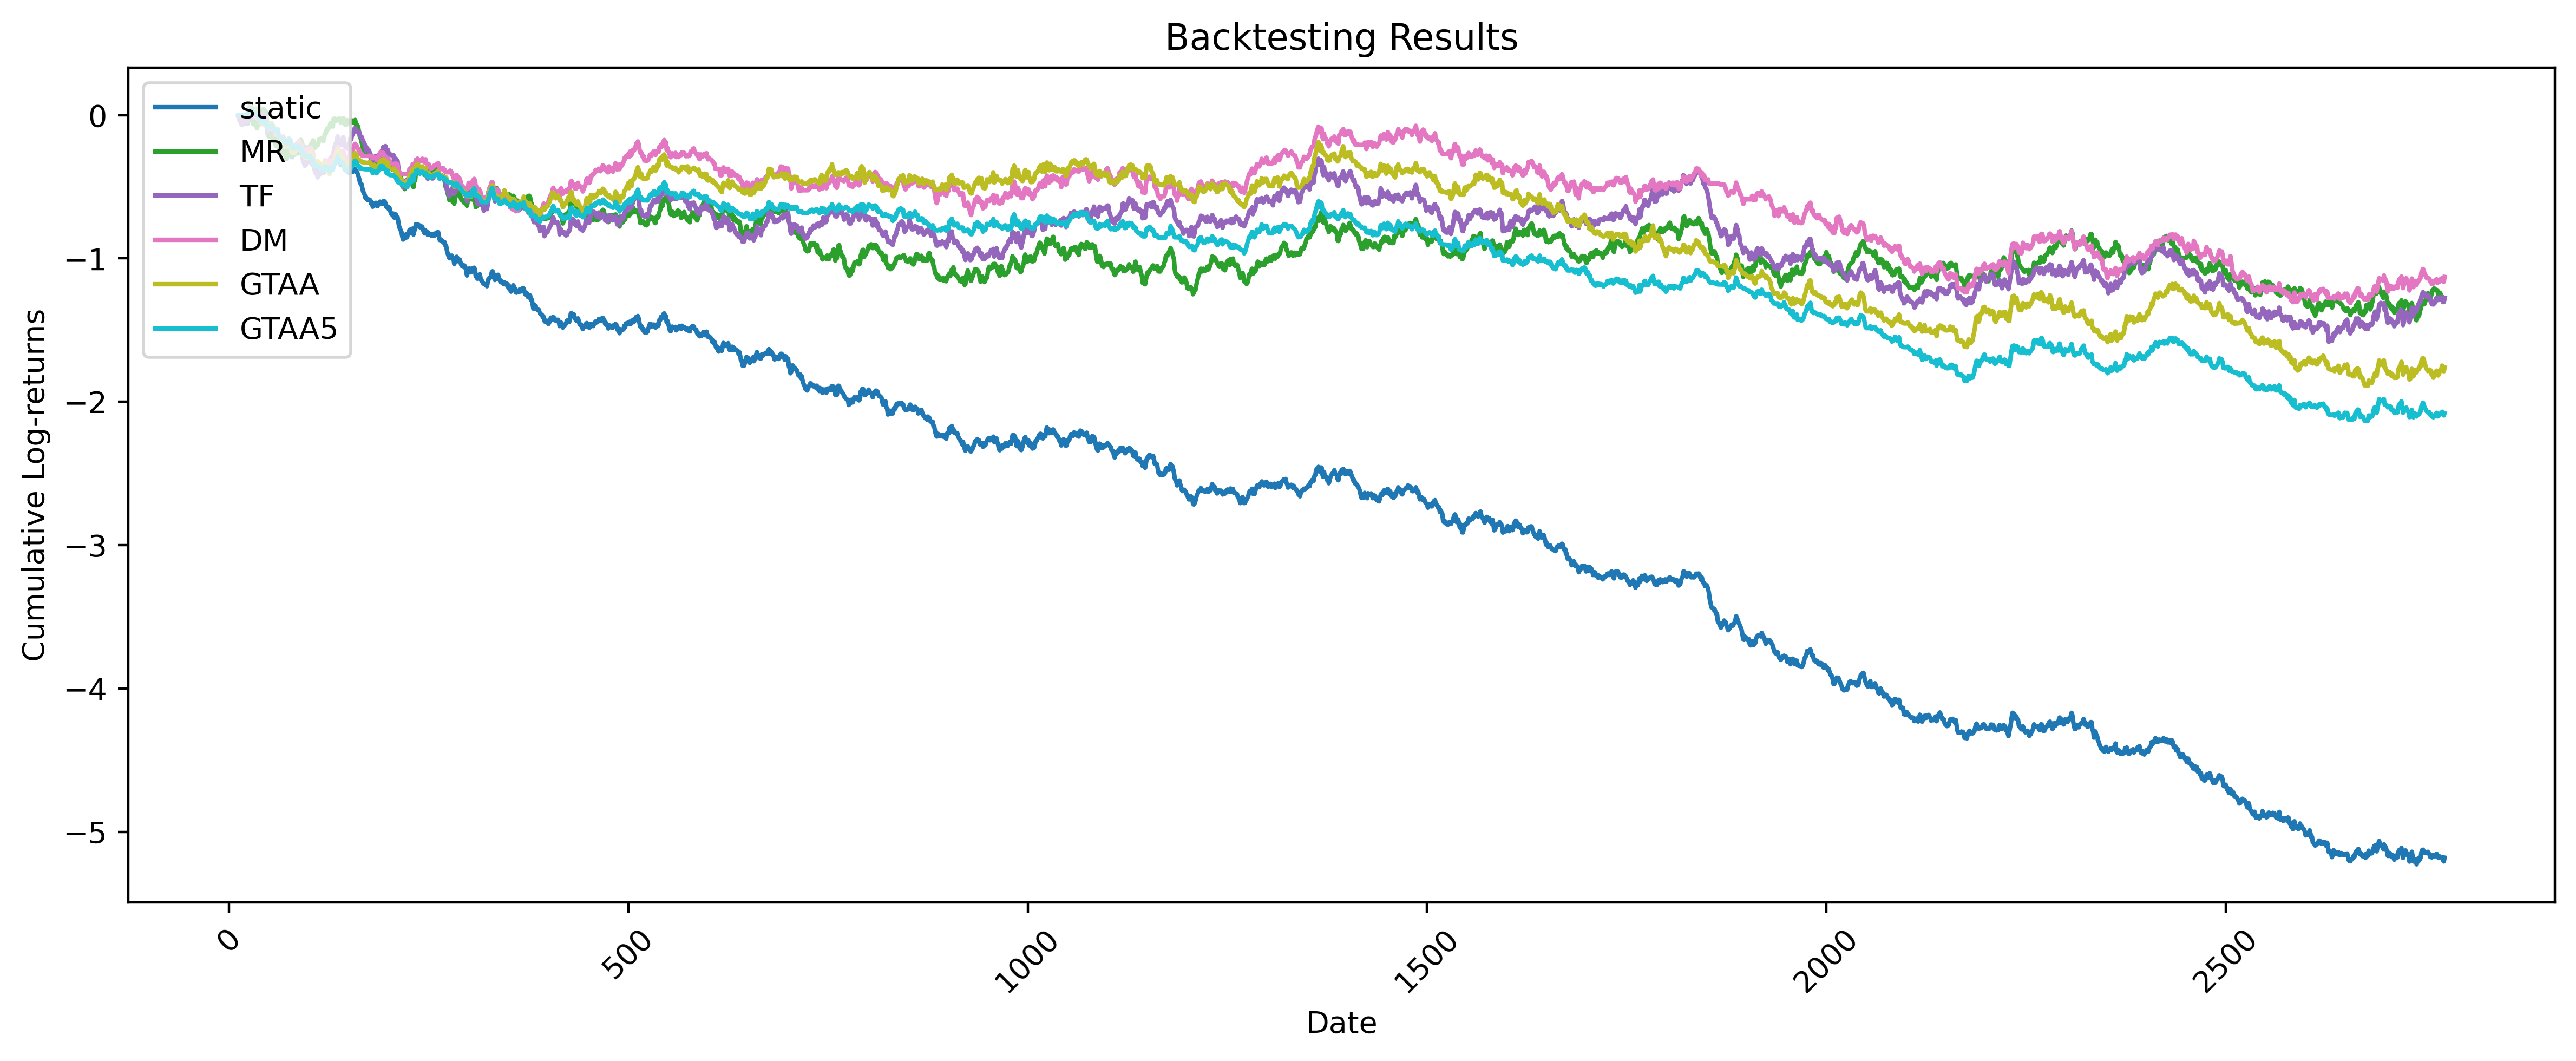

In [10]:
bt.plot_result(result_df.dropna().iloc[:result_df_ori.shape[0]], True)

In [11]:
P_gen = result_df.dropna().values[np.random.choice(P_real.shape[0], 532)]
alpha = 0.05

RE_lst = []
for i in range(100):
    RE = compute_RE(P_real, P_gen, alpha)
    RE_lst.append(RE)

print("Sampling Error:", np.mean(RE_lst))

Sampling Error: 0.17711828649044037


# sigCWGAN Price Scenario

In [12]:
device = 'cpu'
experiment_dir = './numerical_results/VAR/stock/seed=0/SigCWGAN'
base_config = BaseConfig(device=device)
p, q = base_config.p, base_config.q
x_real = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
dim = x_real.shape[-1]
G_weights = load_pickle(os.path.join(experiment_dir, 'G_weights.torch'))
G = SimpleGenerator(dim * p, dim, base_config.hidden_dims, dim).to(device)
G.load_state_dict(G_weights)

with torch.no_grad():
    x_fake = G.sample(5000, x_past[0:1])

x_fake = x_fake.squeeze()
x_fake = x_fake.cpu().detach().numpy()
r_simple_fake = x_fake * std + mean
# r_simple_fake = np.exp(r_log_fake) - 1  # shape: (10, T)

sig_ret_df = pd.DataFrame(r_simple_fake, columns=returns.columns)

initial_price = df_.dropna(axis=0).iloc[0, :]
sig_pri_df = initial_price * (1 + sig_ret_df).cumprod(axis=0)

returns3 = bt.get_momentum(sig_pri_df, 1)
momentum_12m = bt.get_momentum(sig_pri_df, 12)

weight_dict3 = {}
str_name_lst = ['static', 'MR', 'TF', 'DM', 'GTAA', 'GTAA5']

weight_dict3[str_name_lst[0]] = bt.buy_and_hold_strategy(sig_pri_df)
weight_dict3[str_name_lst[1]] = bt.mean_reversion_zscore_strategy(sig_pri_df)
weight_dict3[str_name_lst[2]] = bt.trend_following_zscore_strategy(sig_pri_df)
weight_dict3[str_name_lst[3]] = bt.dual_momentum_strategy(momentum_12m)
weight_dict3[str_name_lst[4]] = bt.gtaa_aggressive3_strategy(momentum_12m, sig_pri_df)
weight_dict3[str_name_lst[5]] = bt.gtaa5_momentum_strategy(momentum_12m, sig_pri_df)

In [13]:
result_df = pd.DataFrame()
for str_name in str_name_lst:
    result_df = bt.return_Table(weight_dict3[str_name], returns3, result_df, True, 'Neutral', True, 0.0002)

result_df.columns = str_name_lst

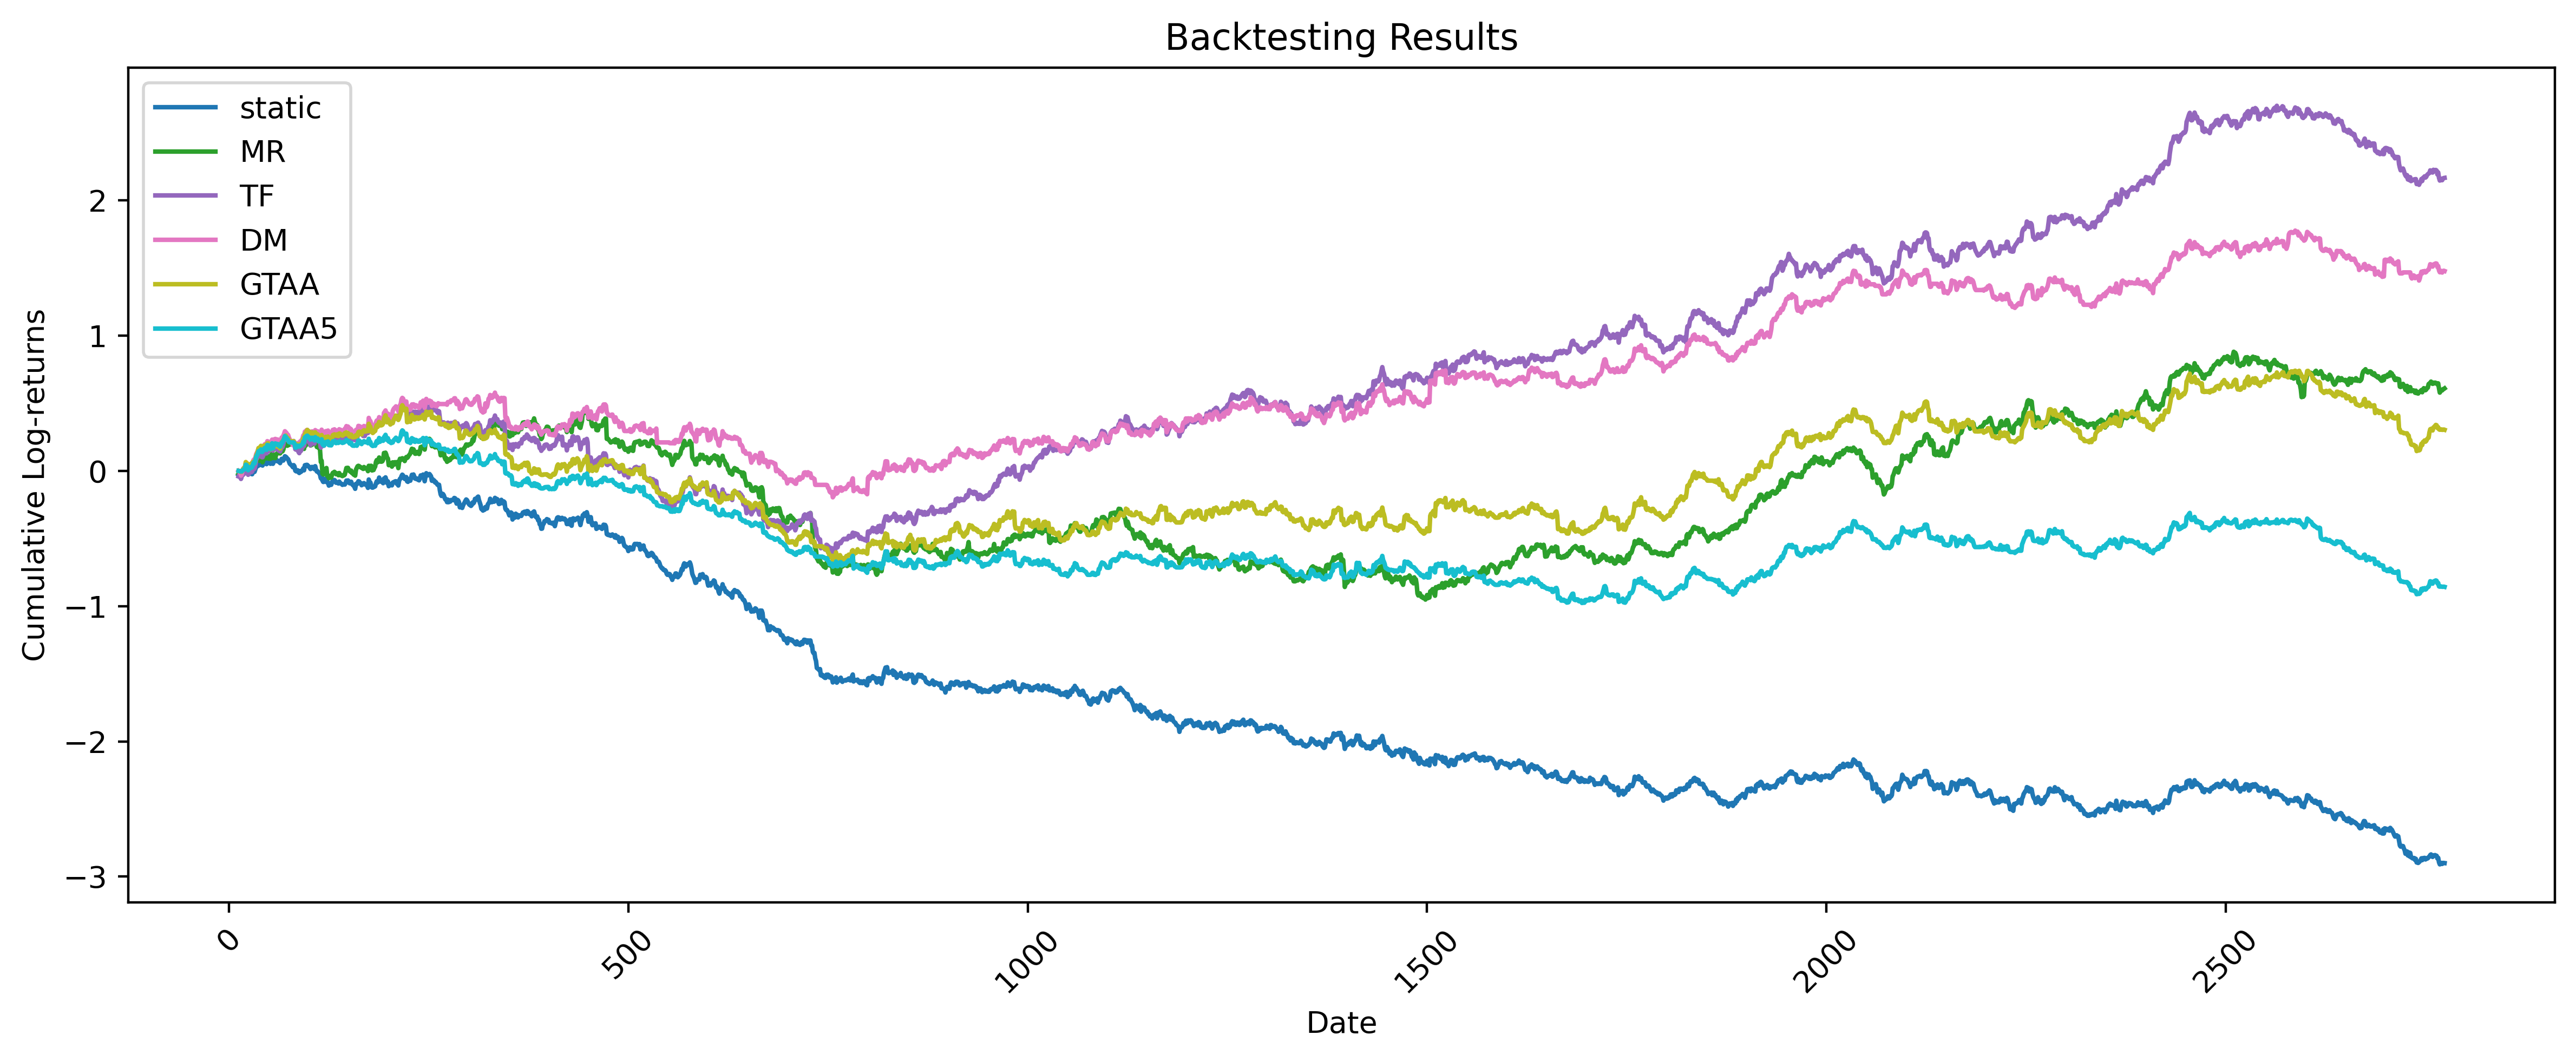

In [14]:
bt.plot_result(result_df.dropna().iloc[:result_df_ori.shape[0]], True)

In [15]:
P_gen = result_df.dropna().values[np.random.choice(P_real.shape[0], 532)]
alpha = 0.05

RE_lst = []
for i in range(100):
    RE = compute_RE(P_real, P_gen, alpha)
    RE_lst.append(RE)

print("Sampling Error:", np.mean(RE_lst))

Sampling Error: 0.08500313013792038


In [16]:
df_

,AAPL,DIS,XOM,INTC,MSFT,AMZN,NVDA,CRM,GOOG,TSLA
datadate,,,,,,,,,,
2014-03-28,536.86,78.99,97.70,25.620,40.30,338.290,17.90,55.75,559.99,212.37
2014-03-31,536.74,80.07,97.68,25.814,40.99,336.365,17.91,57.09,556.97,208.45
2014-04-01,541.65,81.57,97.73,25.990,41.42,342.990,18.65,58.80,567.16,216.97
2014-04-02,542.55,81.67,97.95,25.890,41.35,341.960,18.53,58.15,567.00,230.29
2014-04-03,538.79,81.69,97.93,26.410,41.01,333.620,18.73,55.74,569.74,225.40
...,...,...,...,...,...,...,...,...,...,...
2025-03-17,214.00,99.36,113.76,25.690,388.70,195.740,119.53,280.75,166.57,238.01
2025-03-18,212.69,99.35,113.64,25.920,383.52,192.820,115.43,278.73,162.67,225.31
2025-03-19,215.24,100.29,115.41,24.120,387.82,195.540,117.52,279.39,166.28,235.86


In [23]:
MC_pri_df.to_csv('data/fake_scenario_MC.csv')

In [24]:
sig_pri_df.to_csv('data/fake_scenario_sig.csv')

In [16]:
# rand_day = True
# if rand_day:
#     results = Parallel(n_jobs=8)(delayed(simulate_rand_day)(momentum_12m) for _ in tqdm(range(1000)))
#     result_df = pd.concat(results, axis=1)
#     print(estimate_VaR_ES(result_df, 5))
#
# rand_company = False
# if rand_company:
#     results = Parallel(n_jobs=8)(delayed(simulate_rand_company)(price_df) for _ in tqdm(range(1000)))
#     result_df = pd.concat(results, axis=1)
#     print(estimate_VaR_ES(result_df, 5))
#
# MC = True
# if MC:
#     n_simulations = 3700
#     n_assets = returns.shape[1]
#
#     mu = returns.mean().values
#     cov = returns.cov().values
#     L = np.linalg.cholesky(cov)
#
#     Z = np.random.normal(size=(n_simulations, n_assets))
#     correlated_returns = Z @ L.T
#
#     simulated_returns = correlated_returns + mu.reshape(1, -1)
#     MC_ret_df = pd.DataFrame(simulated_returns, columns=returns.columns)
#
#     initial_price = df_.dropna(axis=0).iloc[0, :]
#     MC_pri_df = initial_price * (1 + MC_ret_df).cumprod(axis=0)
#
#     fake_returns = bt.get_momentum(MC_pri_df, 1)
#     fake_momentum_12m = bt.get_momentum(MC_pri_df, 12)
#     result_df = pd.DataFrame()
#     weights = bt.dual_momentum_strategy(fake_momentum_12m)
#     result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)
#
#     print(estimate_VaR_ES(result_df, 5))
#
# sig = True
# if sig:
#     device = 'cpu'
#     experiment_dir = './numerical_results/VAR/stock/seed=0/SigCWGAN'
#     base_config = BaseConfig(device=device)
#     p, q = base_config.p, base_config.q
#     x_real = load_pickle(os.path.join(os.path.dirname(experiment_dir), 'x_real_test.torch')).to(device)
#     x_past, x_future = x_real[:, :p], x_real[:, p:p + q]
#     dim = x_real.shape[-1]
#     G_weights = load_pickle(os.path.join(experiment_dir, 'G_weights.torch'))
#     G = SimpleGenerator(dim * p, dim, base_config.hidden_dims, dim).to(device)
#     G.load_state_dict(G_weights)
#
#     with torch.no_grad():
#         x_fake = G.sample(2762, x_past[0:1])
#
#     x_fake = x_fake.squeeze()
#     x_fake = x_fake.cpu().detach().numpy()
#     r_log_fake = x_fake * std + mean
#     r_simple_fake = np.exp(r_log_fake) - 1  # shape: (10, T)
#
#     sig_ret_df = pd.DataFrame(r_simple_fake, columns=returns.columns)
#
#     initial_price = df_.dropna(axis=0).iloc[0, :]
#     sig_pri_df = initial_price * (1 + sig_ret_df).cumprod(axis=0)
#
#     fake_returns = bt.get_momentum(sig_pri_df, 1)
#     fake_momentum_12m = bt.get_momentum(sig_pri_df, 12)
#     result_df = pd.DataFrame()
#     weights = bt.dual_momentum_strategy(fake_momentum_12m)
#     result_df = bt.return_Table(weights, fake_returns, result_df, True, 'Neutral', True, False)
#
#     print(estimate_VaR_ES(result_df, 5))

In [17]:
print(r_simple_real.shape)
print(MC_ret_df.shape)
print(sig_ret_df.shape)

(2762, 10)
(5000, 10)
(5000, 10)


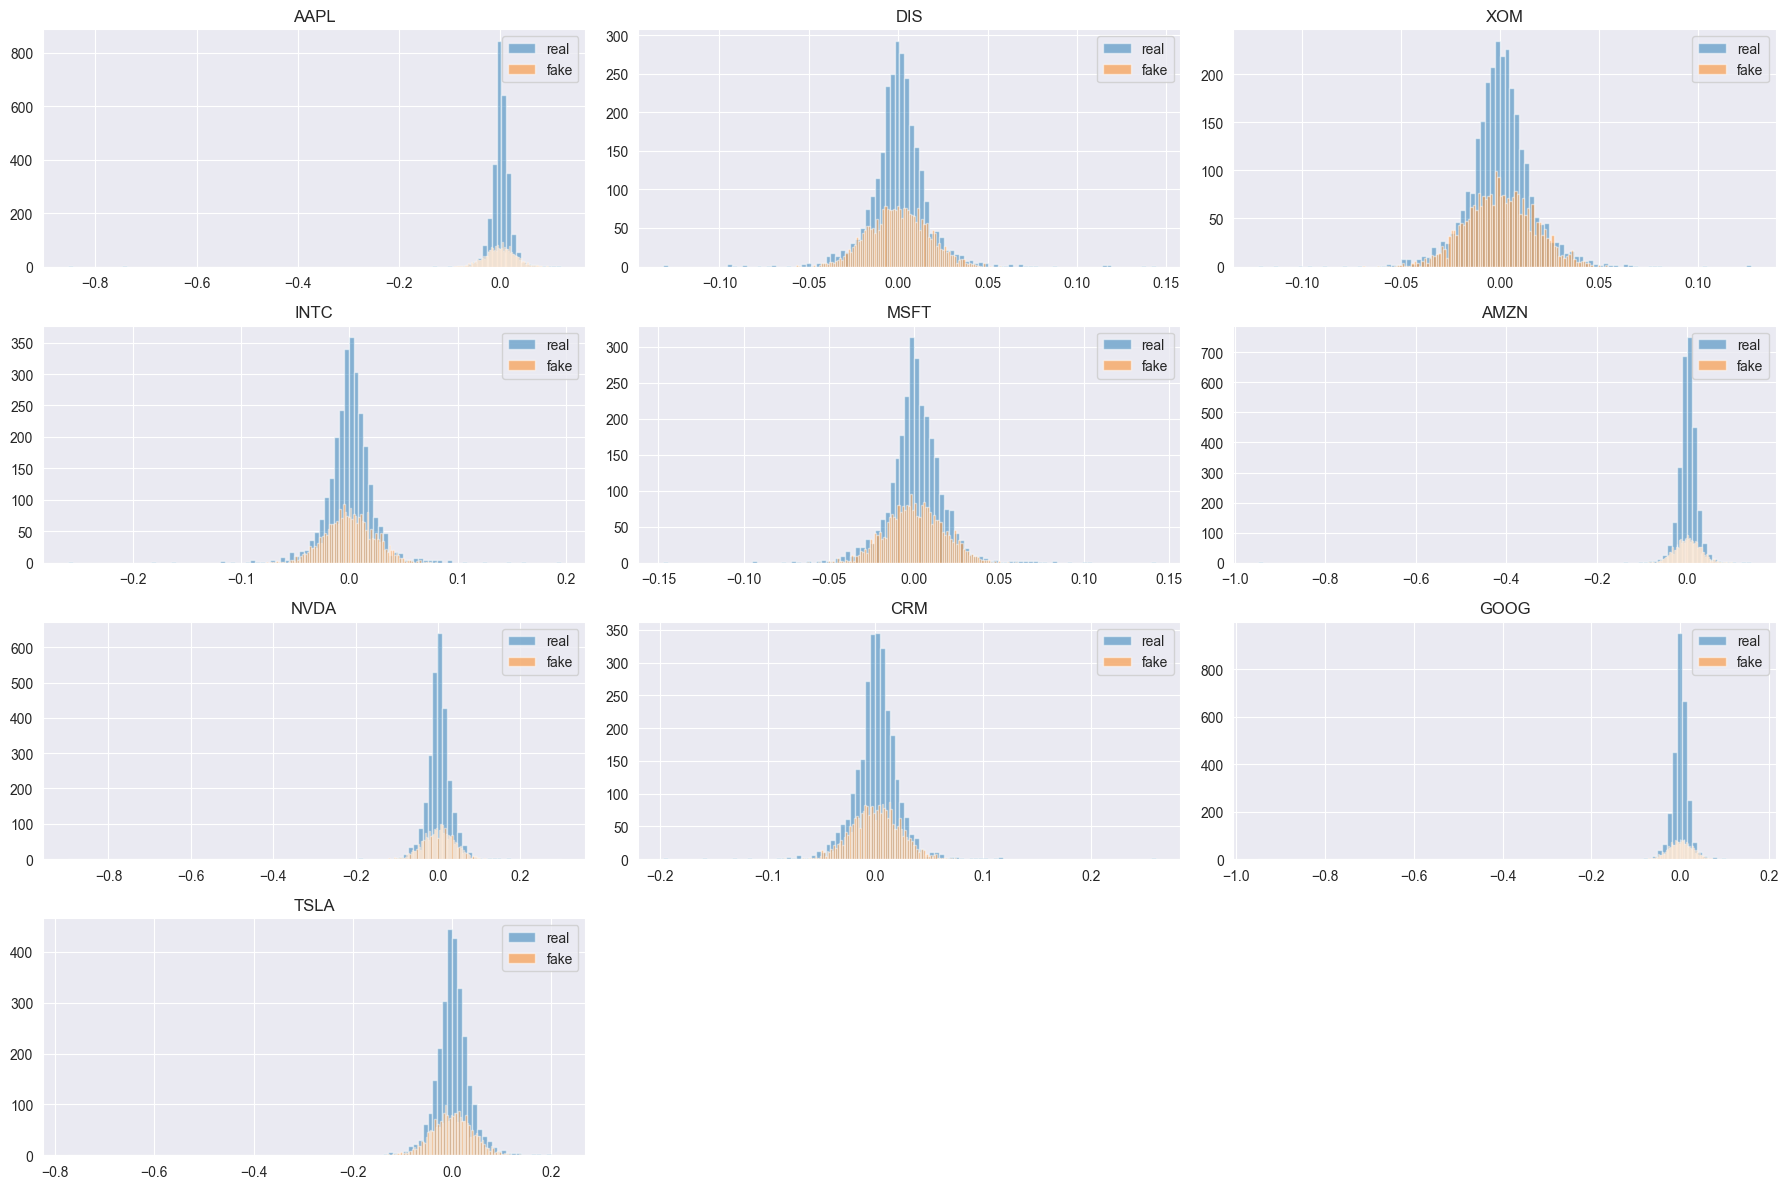

In [26]:
# 예시 데이터 다시 정의
company_names = ['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOG', 'TSLA']

# Subplot 구성
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i in range(len(company_names)):
    ax = axes[i]
    ax.hist(r_simple_real.values[:, i], bins=100, label='real', alpha=0.5)
    ax.hist(MC_ret_df.values[:r_simple_real.shape[0], i], bins=100, label='fake', alpha=0.5)

    ax.set_title(company_names[i])
    ax.legend()

# 남은 subplot 제거
for i in range(len(company_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


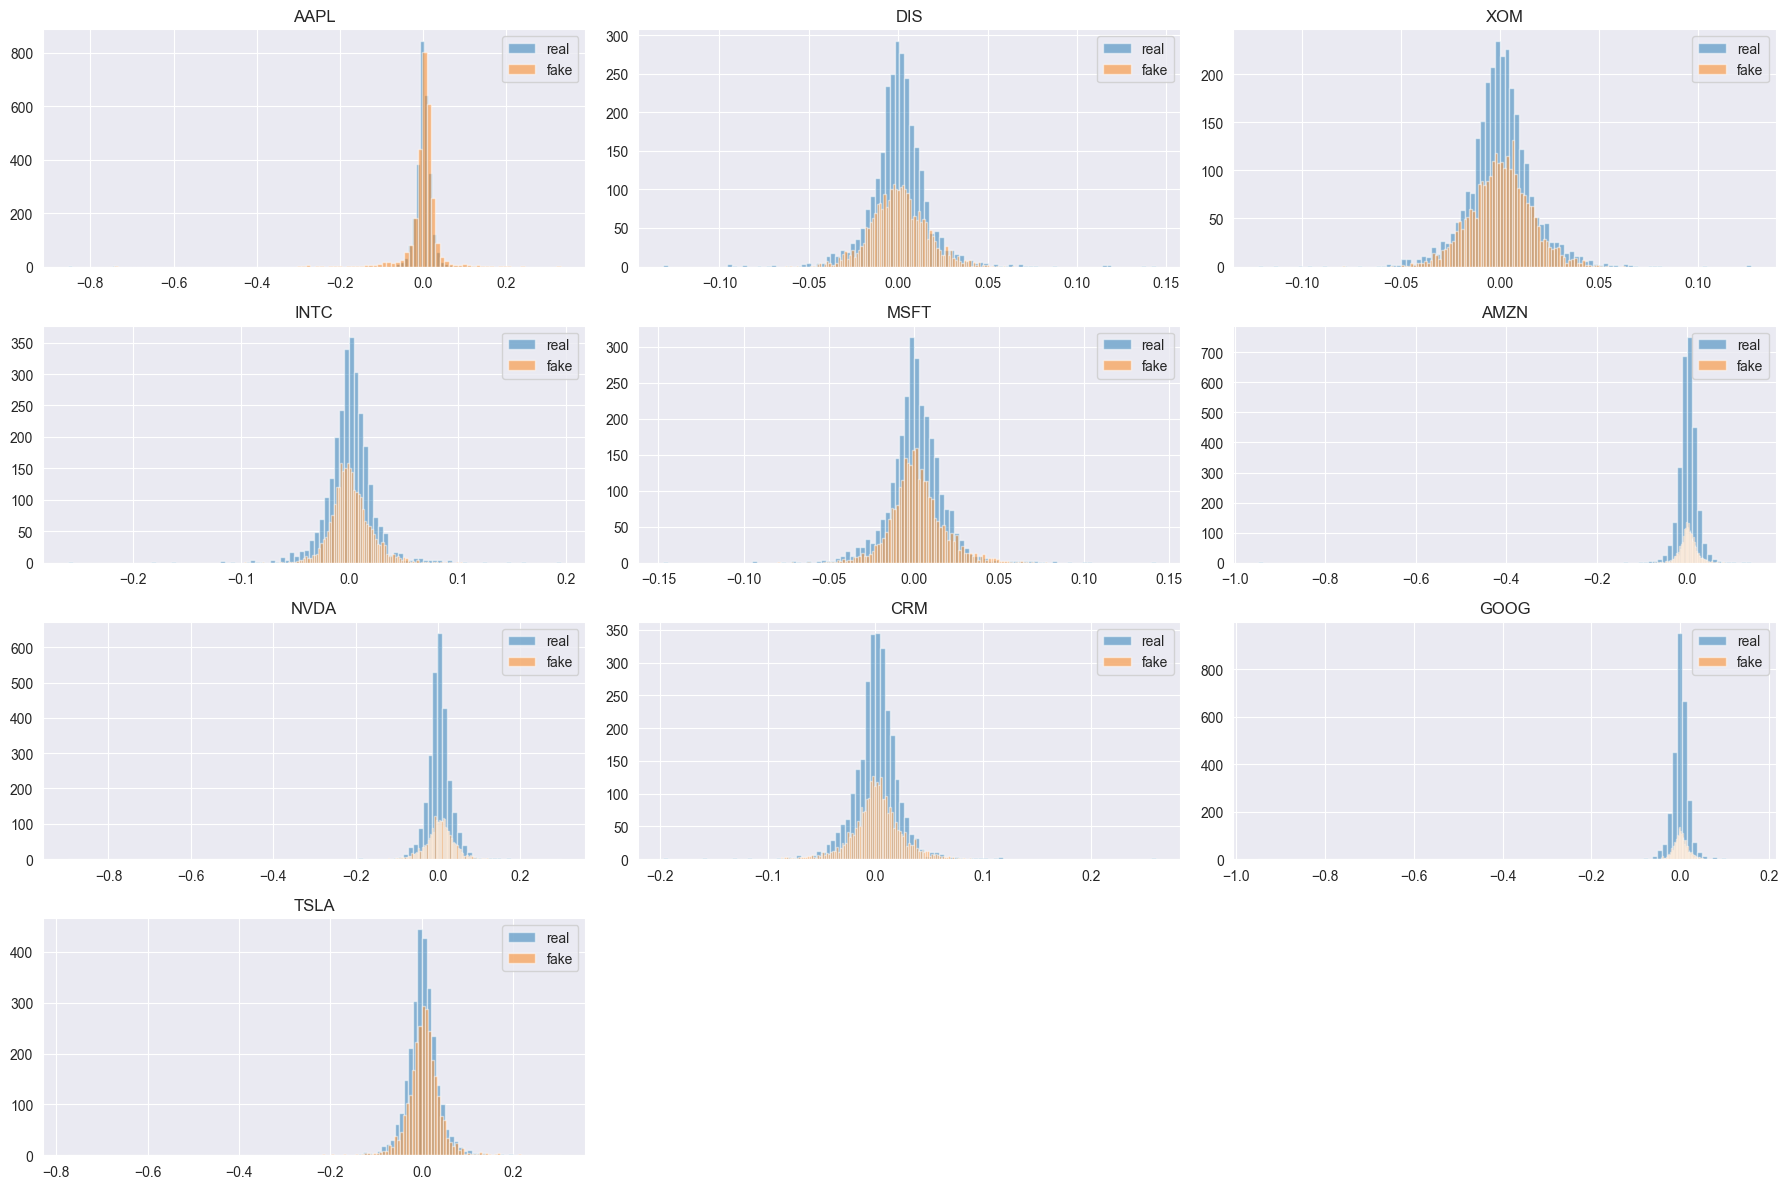

In [19]:
# 예시 데이터 다시 정의
company_names = ['AAPL', 'DIS', 'XOM', 'INTC', 'MSFT', 'AMZN', 'NVDA', 'CRM', 'GOOG', 'TSLA']

# Subplot 구성
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i in range(len(company_names)):
    ax = axes[i]
    ax.hist(r_simple_real.values[:, i], bins=100, label='real', alpha=0.5)
    ax.hist(sig_ret_df.values[:r_simple_real.shape[0], i], bins=100, label='fake', alpha=0.5)
    ax.set_title(company_names[i])
    ax.legend()

# 남은 subplot 제거
for i in range(len(company_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
